# Amyloid & prion protein classification

Based upon code & knowledge outlined at https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

## Preprocess
### Parse FASTA into CSV
The PLAAC dataset is in FASTA format, which will be parsed into a CSV table for preprocessing. We'll record the gene name, Uniprot sequence range & sequence text, and add positive prion & amyloid classifications.

In [1]:
plaacFasta = 'positiveExamples/yeastPrion.fasta'
negativeFasta = 'negativeExamples/negative.fasta'
positiveDataset = 'positiveExamples/positiveDataset.csv'
negativeDataset = 'negativeExamples/negativeDataset.csv'
destination_folder = "./output"

def fastaToCSV(fastaPath, csvPath, prionClassification = 0, amyloidClassification = 0):
    # Read in FASTA
    with open(fastaPath, 'r') as file:
        lines = ["header,sequence,prion,amyloid"]
        lines_i = file.readlines()

        seq = ''
        index = 0
        while index < len(lines_i):
            if lines_i[index][0] == '>':
                'Fasta head line'
                # append sequence & prion classification
                if seq: lines.append(seq + ',' + str(prionClassification) + ',' + str(amyloidClassification))
                seq = ''
                # remove FASTA syntactic sugar
                seq_id = lines_i[index].strip().replace(',', '').replace('>', '')
                # remove uniprot metadata using pipe & equal sign delimiter
                seq_id = " ".join((seq_id.split(" "))[1:]) if "|" in seq_id else seq_id
                lastHeaderIndex = seq_id.index("=") - 3 if ('=' in seq_id) else len(seq_id)
                lines.append('\n' + seq_id[:lastHeaderIndex] + ',')
            else:
                'Sequence line'
                seq += lines_i[index].strip()
                if (index == len(lines_i) - 1): lines.append(seq + ',' + str(prionClassification) + ',' + str(amyloidClassification))
            index += 1
        lines.append("\n")
        file.close()

    # Output CSV file
    with open(csvPath, 'w') as file:
        file.writelines(lines)
        file.close()
    return

# negative
fastaToCSV(negativeFasta, negativeDataset)
# PLAAC prions
fastaToCSV(plaacFasta, positiveDataset, 1, 1)


### Parse JSON into CSV
The Amypro dataset is in JSON format, so we'll use JSON tools to parse data into a CSV table of the same format as above. 

In [2]:
import json 
import csv 

amyproDataset = 'positiveExamples/amyproAmyloids.json'

with open(amyproDataset, encoding = 'utf-8-sig') as json_file: 
    data = json.load(json_file) 
    lines = []
    for amyloid in data:
        lines.append(amyloid["protein_name"].replace(',', '') + (' [' + amyloid["uniprot_start"] + '-' + amyloid["uniprot_end"] + ']' if amyloid["uniprot_start"] != "" else "")+ ',')
        lines.append(amyloid["sequence"] + ',')
        lines.append(str(amyloid["prion_domain"]) + ',')
        # positive amyloid classification
        lines.append('1' + '\n')
    json_file.close()

# Append to CSV file
with open(positiveDataset, 'a') as file:
    file.writelines(lines)
    file.close()

### Read CSVs into a Panda dataframe to generate training, testing & validation datasets
For performance reasons, header names are replaced with indexes that reference an in-memory dictionary. A constant random seed may be assigned to ensure the same data is split across training, testing & validation.

In [3]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split, KFold

train_validation_ratio = 0.85
train_test_ratio = 0.7
df_train, df_test = pd.DataFrame(), pd.DataFrame()

def generateDataFrames(randomSeed):
    # Read raw data & combine 
    df_positive = pd.read_csv(positiveDataset).applymap(lambda x: x.strip() if type(x)==str else x)
    df_negative = pd.read_csv(negativeDataset).applymap(lambda x: x.strip() if type(x)==str else x)
    df_full = pd.concat([df_positive, df_negative], ignore_index=True)

    # Generate in-memory index for headers & compress dataframe
    datasetIndex = {}
    for index in range(len(df_full.index)):
        datasetIndex[index] = df_full.at[index, 'header']
        df_full.at[index, 'header'] = index

    # Split amyloid class
    df_notAmyloid = df_full[df_full['amyloid'] == 0]
    df_amyloid = df_full[df_full['amyloid'] == 1]

    # Train-validation split
    df_amyloid_trainSuperset, df_amyloid_validation = train_test_split(df_amyloid, train_size = train_validation_ratio, random_state = randomSeed)
    df_notAmyloid_trainSuperset, df_notAmyloid_validation  = train_test_split(df_notAmyloid, train_size = train_validation_ratio, random_state = randomSeed)

    # Train-test split
    df_amyloid_train, df_amyloid_test = train_test_split(df_amyloid_trainSuperset, train_size = train_test_ratio, random_state = randomSeed)
    df_notAmyloid_train, df_notAmyloid_test = train_test_split(df_notAmyloid_trainSuperset, train_size = train_test_ratio, random_state = randomSeed)

    # Concatenate splits of different labels into training, testing & validation sets
    df_train = pd.concat([df_amyloid_train, df_notAmyloid_train], ignore_index=True, sort=False)
    df_test = pd.concat([df_amyloid_test, df_notAmyloid_test], ignore_index=True, sort=False)
    df_valid = pd.concat([df_amyloid_validation, df_notAmyloid_validation], ignore_index=True, sort=False)
    df_full = pd.concat([df_train, df_test], ignore_index=True, sort=False)

    # Write preprocessed data
    df_train.to_csv('train.csv', index=False)
    df_test.to_csv('test.csv', index=False)
    df_valid.to_csv('valid.csv', index=False)
    df_full.to_csv('full.csv', index=False)

    return datasetIndex



## Implement the model
### Import necessary libraries

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

# set processing device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu") # MPS device with GRU returns NaN: https://github.com/pytorch/pytorch/issues/94691

# data 

import random
from sklearn.model_selection import KFold
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# model

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# training

import torch.optim as optim

# evaluation

from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns


In [26]:
device

device(type='cpu')

### Load data


In [27]:
# Tokenize peptide sequences by splitting into individual amino acids
def split(sequence):
    return [char for char in sequence]

import pandas as pd
from sklearn.model_selection import train_test_split

class AmyloidDataset(Dataset):
    def __init__(self, dataframe, vocab, tokenizer):
        self.data = dataframe
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data.iloc[idx]['sequence']
        sequence = [self.vocab[token] for token in self.tokenizer(sequence)]
        header = self.data.iloc[idx]['header']
        
        prion = self.data.iloc[idx]['prion'] if 'prion' in self.data.columns else None
        amyloid = self.data.iloc[idx]['amyloid'] if 'amyloid' in self.data.columns else None

        return header, sequence, prion, amyloid

    
datasetIndex = generateDataFrames(0)
# Load CSV data
df_train = pd.concat([pd.read_csv('train.csv'), pd.read_csv('test.csv')], ignore_index=True)

# Generate vocabulary
tokenizer = get_tokenizer(split)
vocab = build_vocab_from_iterator(map(tokenizer, df_train['sequence']))


/var/folders/vp/rd7xppxs0tx1msdtwy779hk40000gn/T/ipykernel_4656/1775970600.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_positive = pd.read_csv(positiveDataset).applymap(lambda x: x.strip() if type(x)==str else x)
/var/folders/vp/rd7xppxs0tx1msdtwy779hk40000gn/T/ipykernel_4656/1775970600.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_negative = pd.read_csv(negativeDataset).applymap(lambda x: x.strip() if type(x)==str else x)


In [28]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

### Model
A stacked, bidirectional gated recurrent unit (GRU) network will be applied to learn amyloidogenic & prionogenic relations in peptide sequences. 

This network is composed of an embedding layer to vectorize input sequences, two GRU layers, and a fully-connected linear output layer gated by sigmoidal activation.

Hyperparameters:
- embedding & hidden layer dimensions
- layer depth
- bidirectionality
- neuron dropout probability

In [29]:
class GRU(nn.Module):

    def __init__(self, vocab, dimension=128, sequenceDepth = 64, dropoutWithinLayers = 0.3, dropoutOutput = 0.3):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(len(vocab), sequenceDepth)
        self.dimension = dimension
        self.GRU = nn.GRU(input_size=sequenceDepth,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True,
                            dropout=dropoutWithinLayers)
        self.dropOutput = nn.Dropout(p=dropoutOutput)

        # output layer
        self.fc = nn.Linear(2 * dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.GRU(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.dropOutput(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

#### Second model
A similar, but less performant, long-short term memory model is supplied here.

In [30]:
class LSTM(nn.Module):

    def __init__(self, vocab, dimension=64):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(vocab), 32)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.5)
        self.dropOnOutput = nn.Dropout(p=0.5)

        # output layer
        self.fc = nn.Linear(2 * dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.dropOnOutput(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

## Train

### Training function



In [31]:
#### CSV row index sampler
def sampleCSV(csvFilePath, sampleType, sampler):
    df_full = pd.read_csv(csvFilePath)
    df_sample = df_full.iloc[sampler]
    df_sample.to_csv(destination_folder + '/sample' + sampleType + '.csv', index=False)
    return 'sample' + sampleType + '.csv'


In [32]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    headers, sequences, prions, amyloids = zip(*batch)

    # Compute lengths of sequences
    sequence_lengths = torch.tensor([len(seq) for seq in sequences])

    # Pad sequences and convert to tensor
    sequences_padded = pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True)

    # Convert targets to tensor
    prions = torch.tensor(prions).float()
    amyloids = torch.tensor(amyloids).float()

    return headers, sequences_padded, sequence_lengths, prions, amyloids

def train(vocab,
          tokenizer,
          lr,
          dimension,
          sequenceDepth,
          dropoutWithinLayers,
          dropoutOutput,
          batchSize,
          criterion,
          full_dataset,
          foldCount,
          config,
          file_path,
          num_epochs = 5,
          amyloid = True,
          best_valid_loss = float("inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = {i:[] for i in range(foldCount)}
    valid_loss_list = {i:[] for i in range(foldCount)}
    global_steps_list = {i:[] for i in range(foldCount)}

    # K-fold cross-validation loop
    kfold = KFold(n_splits=foldCount, shuffle=True)
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(full_dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        # Split data
        train_data, test_data = full_dataset.iloc[train_ids], full_dataset.iloc[test_ids]

        # Create datasets
        train_dataset = AmyloidDataset(train_data, vocab, tokenizer)
        test_dataset = AmyloidDataset(test_data, vocab, tokenizer)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batchSize, collate_fn=collate_fn)
        eval_every = len(train_loader) // 2

        # initialize model
        model = GRU(vocab=vocab, dimension=dimension, sequenceDepth=sequenceDepth, dropoutWithinLayers=dropoutWithinLayers, dropoutOutput=dropoutOutput).to(device)
        print(f"Model initialized on {next(model.parameters()).device}")

        # load optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # training loop
        model.train()
        for epoch in range(num_epochs):
            for header, sequence, sequence_length, prionLabel, amyloidLabel in train_loader:
                prionLabel = prionLabel.to(device)
                amyloidLabel = amyloidLabel.to(device)
                sequence = sequence.to(device)
                output = model(sequence, sequence_length)

                amyloidLoss = criterion(output, amyloidLabel)
                prionLoss = criterion(output, prionLabel)
                loss = amyloidLoss if amyloid else prionLoss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update running values
                running_loss += loss.item()
                global_step += 1
                
                # evaluation for this epoch
                if global_step % eval_every == 0:
                    model.eval()
                    with torch.no_grad():                    
                        # validation loop
                        for header, sequence, sequence_length, prionLabel, amyloidLabel in test_loader:
                            prionLabel = prionLabel.to(device)
                            amyloidLabel = amyloidLabel.to(device)
                            sequence = sequence.to(device)
                            output = model(sequence, sequence_length)
                            
                            amyloidLoss = criterion(output, amyloidLabel)
                            prionLoss = criterion(output, prionLabel)
                            loss = amyloidLoss if amyloid else prionLoss
                            valid_running_loss += loss.item()
                
                    # record loss
                    average_train_loss = running_loss / eval_every
                    average_valid_loss = valid_running_loss / len(test_loader)
                    train_loss_list[fold].append(average_train_loss)
                    valid_loss_list[fold].append(average_valid_loss)
                    global_steps_list[fold].append(global_step)

                    # resetting running values
                    valid_running_loss = 0.0
                    running_loss = 0.0
                    model.train()
                    
                    # print progress
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                            .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader)*(foldCount),
                                    average_train_loss, average_valid_loss))
                    
                    if average_valid_loss < best_valid_loss:
                        best_valid_loss = average_valid_loss
                    torch.save(model.state_dict(), file_path + f'/model{fold}.pt')
                    save_metrics(file_path + f'/metrics{fold}.pt', train_loss_list[fold], valid_loss_list[fold], global_steps_list[fold])

    print('Finished Training!')
    return train_loss_list, valid_loss_list, global_steps_list


### Entry point for training

Hyperparameters:
 - Learning rate
 - Epoch count
 - Loss function
 - Hidden layer size
 - Hidden layer depth

In [33]:
best_params = eval("{'dimension': 106,'sequenceDepth': 85,'dropoutWithinLayers': 0.31686011720357404,'dropoutOutput': 0.5638720207488487,'learningRate': 0.0003064907979479033}")

In [34]:
# Declare hyperparameters
config = {
    'number_of_epochs': 5,
    'batch_size': 8,
    'dropout_within_layers': best_params['dropoutWithinLayers'],
    'dropout_output': best_params['dropoutOutput'],
    'learning_rate': best_params['learningRate'],
    'sequence_feature_depth': best_params['sequenceDepth'],
    'dimension': best_params['dimension']
}
foldCount = 10
# Call to train function
train_loss_list, valid_loss_list, global_steps_list = train(
    vocab=vocab,
    tokenizer=tokenizer,
    lr=config['learning_rate'],
    dimension=config['dimension'],
    sequenceDepth=config['sequence_feature_depth'],
    dropoutWithinLayers=config['dropout_within_layers'],
    dropoutOutput=config['dropout_output'],
    batchSize=config['batch_size'],
    criterion=nn.SmoothL1Loss(),
    full_dataset=df_train,
    foldCount=foldCount,
    config=config,
    file_path=destination_folder,
    num_epochs=config['number_of_epochs']
)


FOLD 1
--------------------------------
Model initialized on cpu
Epoch [1/5], Step [17/1750], Train Loss: 0.1200, Valid Loss: 0.1082
Model saved to ==> ./output/metrics0.pt
Epoch [1/5], Step [34/1750], Train Loss: 0.1168, Valid Loss: 0.0931
Model saved to ==> ./output/metrics0.pt
Epoch [2/5], Step [51/1750], Train Loss: 0.0964, Valid Loss: 0.0788
Model saved to ==> ./output/metrics0.pt
Epoch [2/5], Step [68/1750], Train Loss: 0.0884, Valid Loss: 0.0649
Model saved to ==> ./output/metrics0.pt
Epoch [3/5], Step [85/1750], Train Loss: 0.0732, Valid Loss: 0.0511
Model saved to ==> ./output/metrics0.pt
Epoch [3/5], Step [102/1750], Train Loss: 0.0711, Valid Loss: 0.0420
Model saved to ==> ./output/metrics0.pt
Epoch [4/5], Step [119/1750], Train Loss: 0.0726, Valid Loss: 0.0379
Model saved to ==> ./output/metrics0.pt
Epoch [4/5], Step [136/1750], Train Loss: 0.0591, Valid Loss: 0.0340
Model saved to ==> ./output/metrics0.pt
Epoch [5/5], Step [153/1750], Train Loss: 0.0662, Valid Loss: 0.0303

## Evaluate
### Training losses

Model loaded from <== ./output/metrics0.pt
Model loaded from <== ./output/metrics1.pt
Model loaded from <== ./output/metrics2.pt
Model loaded from <== ./output/metrics3.pt
Model loaded from <== ./output/metrics4.pt
Model loaded from <== ./output/metrics5.pt
Model loaded from <== ./output/metrics6.pt
Model loaded from <== ./output/metrics7.pt
Model loaded from <== ./output/metrics8.pt
Model loaded from <== ./output/metrics9.pt


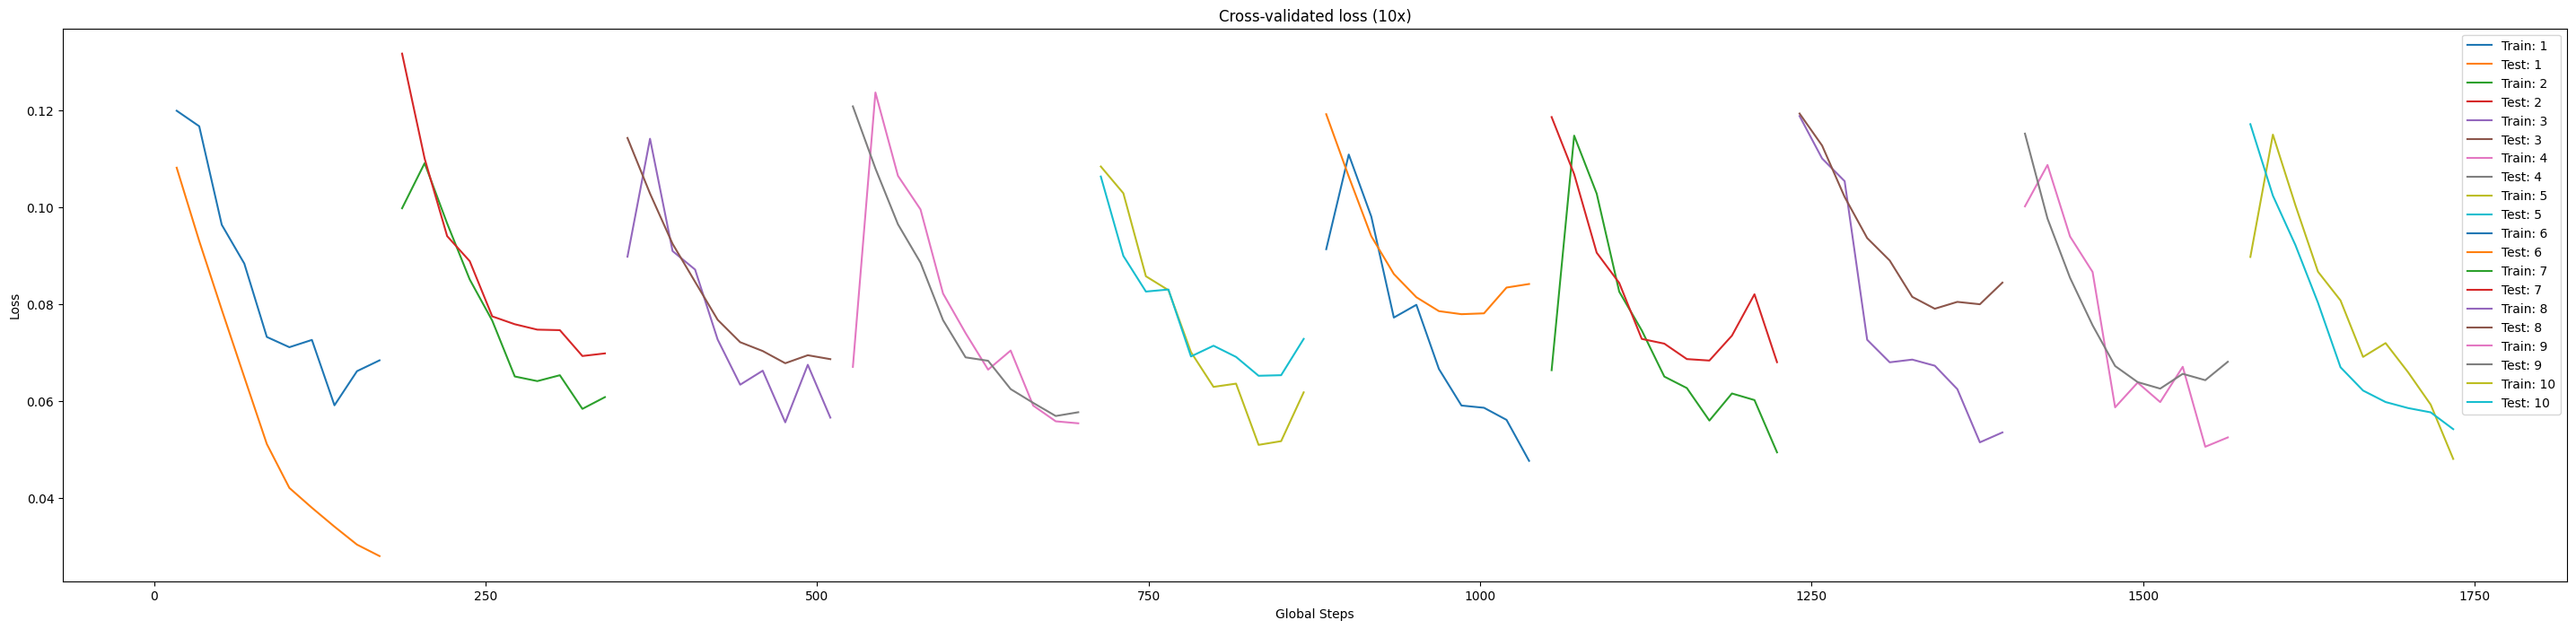

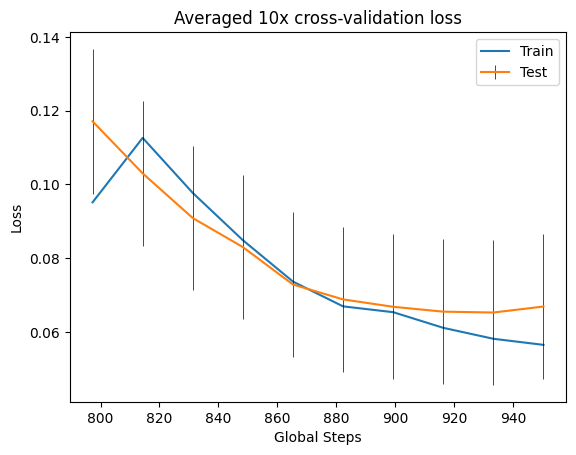

In [35]:
# load saved training losses
def loadSavedCSVList(csvPath):
    savedData = pd.read_csv(destination_folder + csvPath).values.T.tolist()
    savedData.pop(0)
    return pd.DataFrame(np.array(savedData).T.tolist())

# plot loss across folds
plt.figure(figsize=(36,8))
plt.title('Cross-validated loss (10x)')

totalTrainingLosses, totalTestingLosses, totalGlobalSteps = [], [], []
for fold in range(foldCount):
    train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + f'/metrics{fold}.pt')
    totalTrainingLosses.append(np.asarray(train_loss_list)[:10])
    totalTestingLosses.append(np.asarray(valid_loss_list)[:10])
    totalGlobalSteps.append(np.asarray(global_steps_list)[:10])
    plt.plot(global_steps_list, train_loss_list, label=f'Train: {fold+1}')
    plt.plot(global_steps_list, valid_loss_list, label=f'Test: {fold+1}')
    plt.legend()
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.show()

averageTrainingDeviation = [np.std(sublist) for sublist in totalTrainingLosses]
totalTestingDeviation = [np.std(sublist) for sublist in totalTrainingLosses]

globalSteps = pd.DataFrame(global_steps_list)
pd.DataFrame(list(totalGlobalSteps)).to_csv(destination_folder + '/globalSteps.csv', index = False)

pd.DataFrame(list(train_loss_list)).to_csv(destination_folder + '/trainingLosses.csv')
pd.DataFrame(list(totalTestingLosses)).to_csv(destination_folder + '/testingLosses.csv')

# plot average loss across folds
plt.title('Averaged 10x cross-validation loss')
plt.plot(np.mean(totalGlobalSteps, axis=0), np.mean(totalTrainingLosses, axis=0), label='Train')
plt.errorbar(np.mean(totalGlobalSteps, axis=0), np.mean(totalTestingLosses, axis=0), np.mean(totalTestingDeviation, axis=0), label='Test', ecolor='black', elinewidth=0.5)
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### Entry point for model evaluation

In [36]:
def runModel(model, vocab, tokenizer, full_dataset, foldCount=foldCount, threshold=0.5):
    from tqdm import tqdm
    y_pred = []
    y_true = []

    def evaluate(test_dataset, y_pred, y_true):
        test_data = AmyloidDataset(test_dataset, vocab, tokenizer)
        test_loader = DataLoader(test_data, batch_size=16, collate_fn=collate_fn)
        with torch.no_grad():
            for header, sequence, sequence_length, prionLabel, amyloidLabel in tqdm(test_loader, unit='batch', total=len(test_loader)):
                prionLabel = prionLabel.to(device)
                amyloidLabel = amyloidLabel.to(device)
                sequence = sequence.to(device)
                output = model(sequence, sequence_length)
                
                output = (output > threshold).int()
                y_pred.extend(output.tolist())
                y_true.extend(amyloidLabel.tolist())

    model.eval()
    kfold = KFold(n_splits=foldCount, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(full_dataset)):
        print(f'Evaluating FOLD {fold+1}')
        print('--------------------------------')

        # Split data
        _, test_data = full_dataset.iloc[train_ids], full_dataset.iloc[test_ids]

        evaluate(test_data, y_pred, y_true)
    
    return y_pred, y_true


### Classification report, external holdout

Evaluating FOLD 1
--------------------------------


  0%|          | 0/1 [00:00<?, ?batch/s]

100%|██████████| 1/1 [00:00<00:00, 13.75batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 12.84batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.89batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  8.57batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 18.03batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 31.13batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.95batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.33batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.28batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.24batch/s]


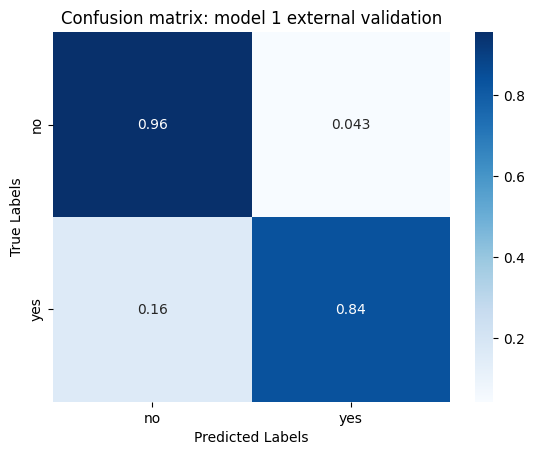

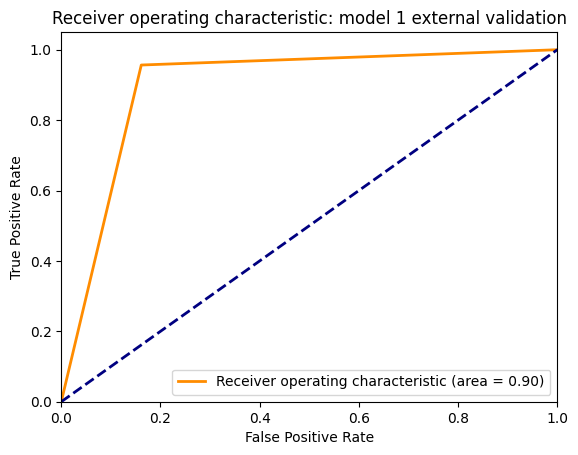

Classification Report
              precision    recall  f1-score   support

           1     0.8148    0.9565    0.8800        23
           0     0.9630    0.8387    0.8966        31

    accuracy                         0.8889        54
   macro avg     0.8889    0.8976    0.8883        54
weighted avg     0.8999    0.8889    0.8895        54

Matthews correlation: 0.7864561805867951
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  6.30batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 17.13batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.48batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 12.07batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.83batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.36batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.34batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.34batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 22.78batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.63batch/s]


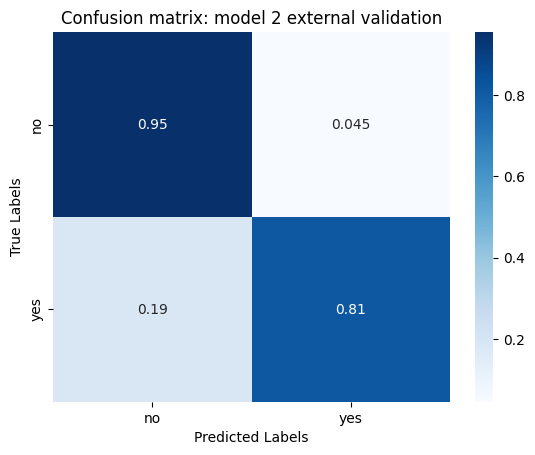

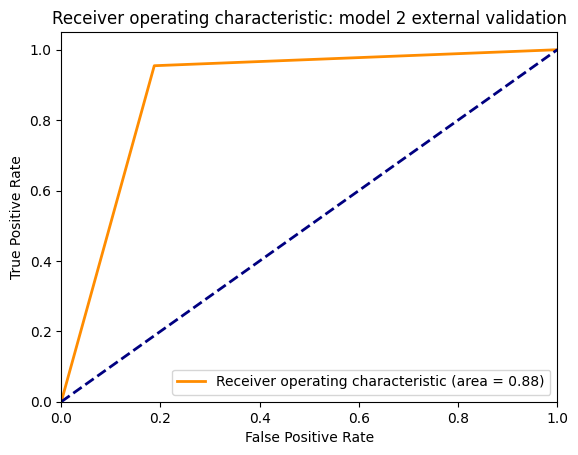

Classification Report 2:
              precision    recall  f1-score   support

           1     0.7778    0.9545    0.8571        22
           0     0.9630    0.8125    0.8814        32

    accuracy                         0.8704        54
   macro avg     0.8704    0.8835    0.8692        54
weighted avg     0.8875    0.8704    0.8715        54

Matthews correlation: 0.753778361444409
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  9.02batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 25.07batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.28batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.44batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 23.56batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.17batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.66batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  9.72batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 22.69batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 17.69batch/s]


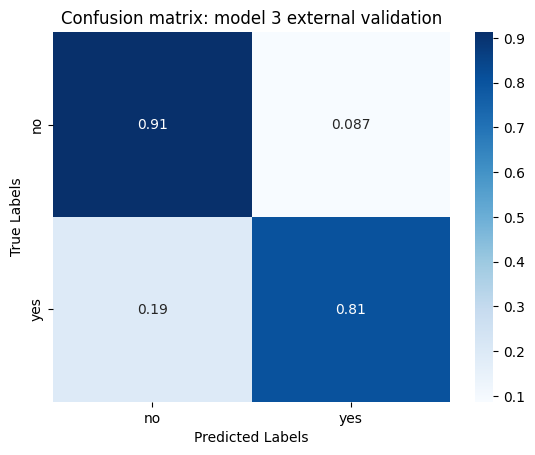

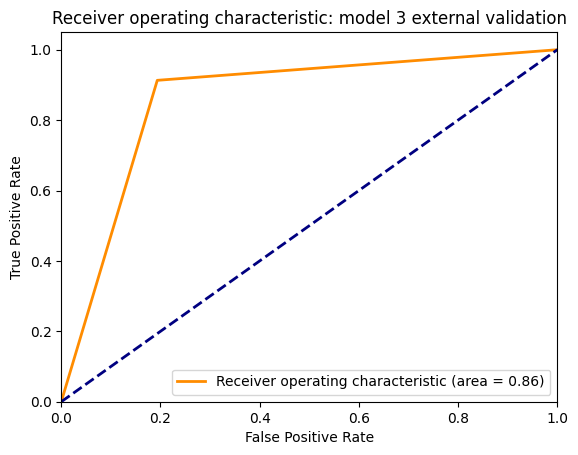

Classification Report 3:
              precision    recall  f1-score   support

           1     0.7778    0.9130    0.8400        23
           0     0.9259    0.8065    0.8621        31

    accuracy                         0.8519        54
   macro avg     0.8519    0.8597    0.8510        54
weighted avg     0.8628    0.8519    0.8527        54

Matthews correlation: 0.7115555919594813
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 20.17batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.14batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.81batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 17.97batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.99batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.23batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 12.68batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 18.99batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 12.36batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.05batch/s]


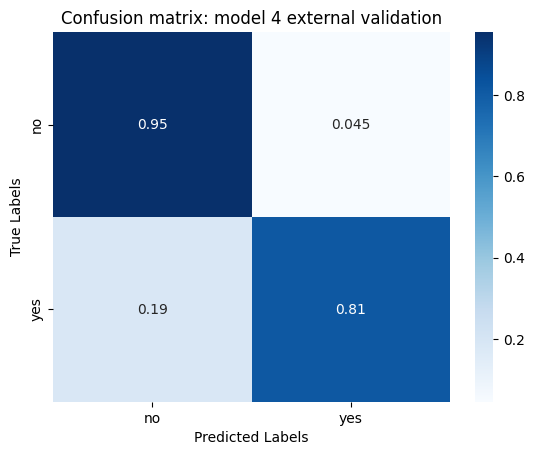

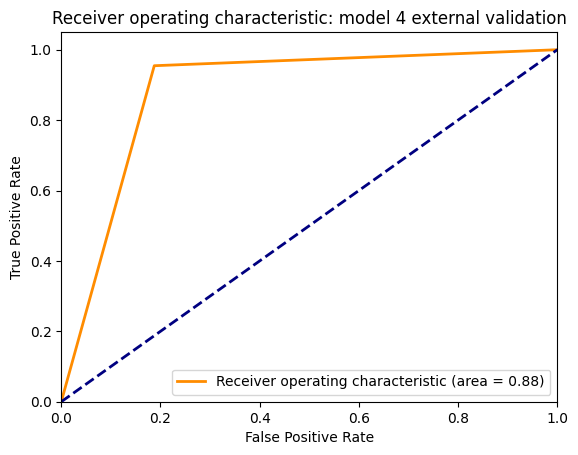

Classification Report 4:
              precision    recall  f1-score   support

           1     0.7778    0.9545    0.8571        22
           0     0.9630    0.8125    0.8814        32

    accuracy                         0.8704        54
   macro avg     0.8704    0.8835    0.8692        54
weighted avg     0.8875    0.8704    0.8715        54

Matthews correlation: 0.753778361444409
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.07batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  9.41batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 25.98batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.53batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.18batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.42batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 12.61batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 21.88batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 12.85batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.93batch/s]


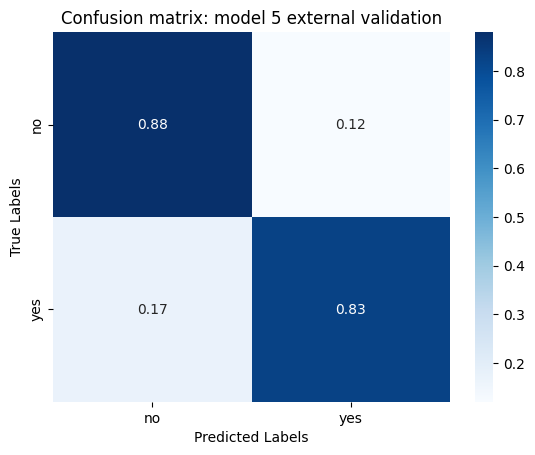

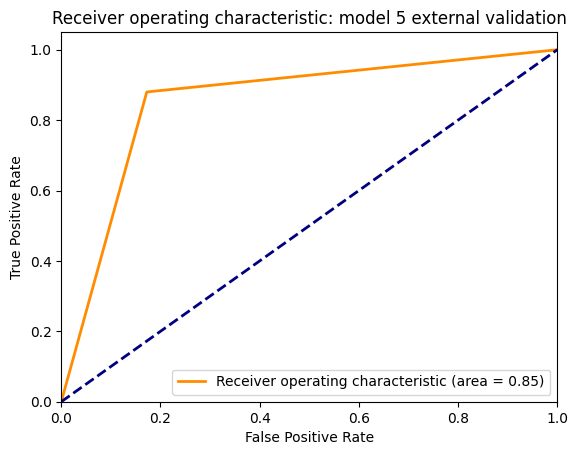

Classification Report 5:
              precision    recall  f1-score   support

           1     0.8148    0.8800    0.8462        25
           0     0.8889    0.8276    0.8571        29

    accuracy                         0.8519        54
   macro avg     0.8519    0.8538    0.8516        54
weighted avg     0.8546    0.8519    0.8521        54

Matthews correlation: 0.705642285072797
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  9.02batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 19.40batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.53batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.01batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.42batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.04batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.79batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 18.43batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.43batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 39.22batch/s]


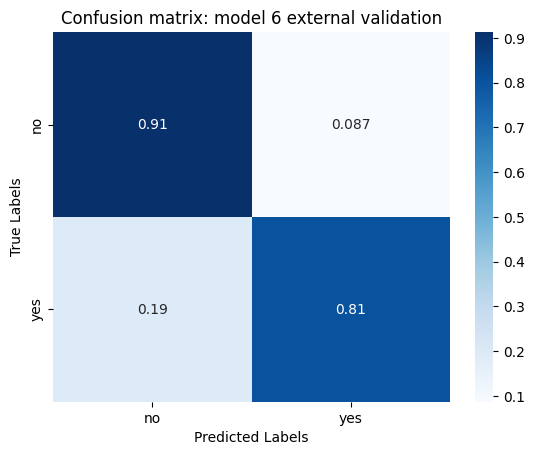

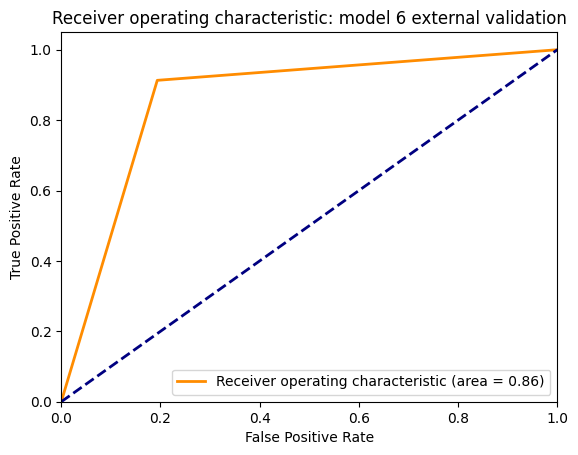

Classification Report 6:
              precision    recall  f1-score   support

           1     0.7778    0.9130    0.8400        23
           0     0.9259    0.8065    0.8621        31

    accuracy                         0.8519        54
   macro avg     0.8519    0.8597    0.8510        54
weighted avg     0.8628    0.8519    0.8527        54

Matthews correlation: 0.7115555919594813
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.63batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.31batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 17.65batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  9.72batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.05batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.48batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 17.97batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 18.80batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.58batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.48batch/s]


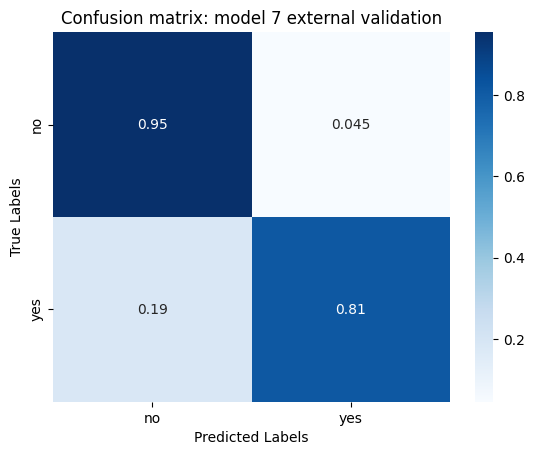

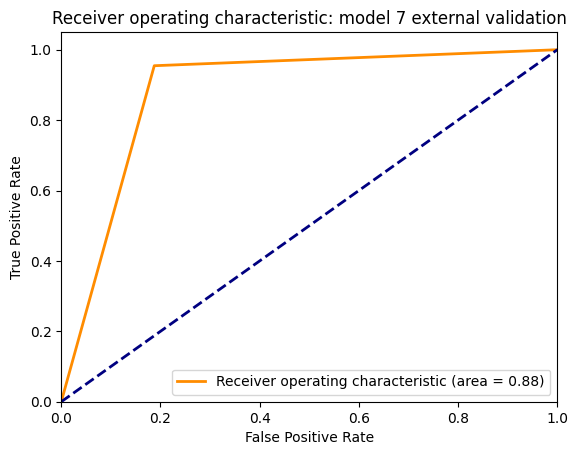

Classification Report 7:
              precision    recall  f1-score   support

           1     0.7778    0.9545    0.8571        22
           0     0.9630    0.8125    0.8814        32

    accuracy                         0.8704        54
   macro avg     0.8704    0.8835    0.8692        54
weighted avg     0.8875    0.8704    0.8715        54

Matthews correlation: 0.753778361444409
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.90batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  8.99batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.50batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 16.52batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 33.00batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.16batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 20.23batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.79batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.73batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.13batch/s]


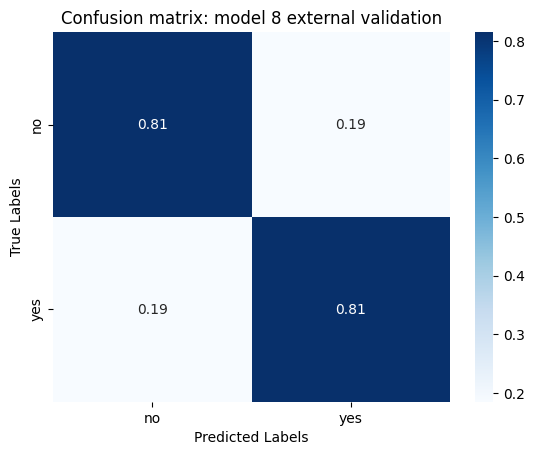

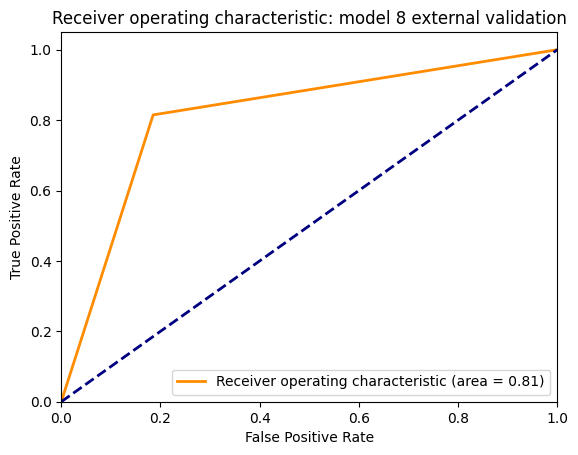

Classification Report 8:
              precision    recall  f1-score   support

           1     0.8148    0.8148    0.8148        27
           0     0.8148    0.8148    0.8148        27

    accuracy                         0.8148        54
   macro avg     0.8148    0.8148    0.8148        54
weighted avg     0.8148    0.8148    0.8148        54

Matthews correlation: 0.6296296296296297
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.33batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.00batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 13.88batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 14.77batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 19.01batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 17.80batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 18.47batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  6.96batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  9.57batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 15.17batch/s]


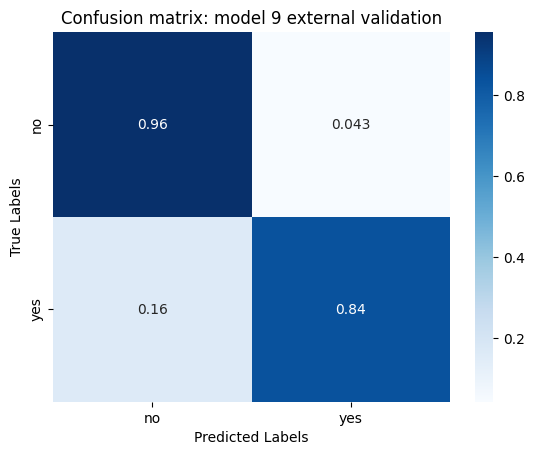

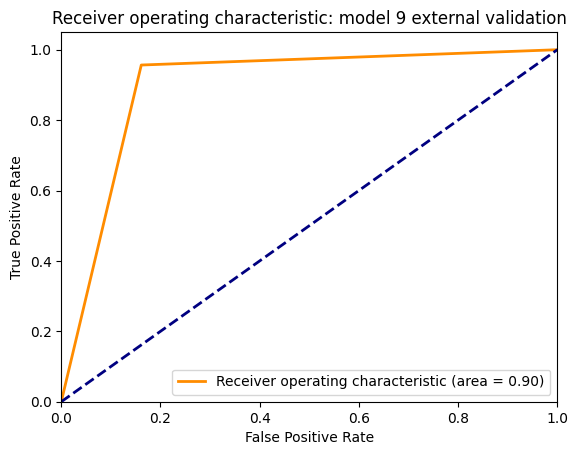

Classification Report 9:
              precision    recall  f1-score   support

           1     0.8148    0.9565    0.8800        23
           0     0.9630    0.8387    0.8966        31

    accuracy                         0.8889        54
   macro avg     0.8889    0.8976    0.8883        54
weighted avg     0.8999    0.8889    0.8895        54

Matthews correlation: 0.7864561805867951
Evaluating FOLD 1
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  9.79batch/s]


Evaluating FOLD 2
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.49batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 10.09batch/s]


Evaluating FOLD 4
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 11.82batch/s]


Evaluating FOLD 5
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 16.01batch/s]


Evaluating FOLD 6
--------------------------------


100%|██████████| 1/1 [00:00<00:00,  7.24batch/s]


Evaluating FOLD 7
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 16.36batch/s]


Evaluating FOLD 8
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 18.11batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 22.53batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 1/1 [00:00<00:00, 20.15batch/s]


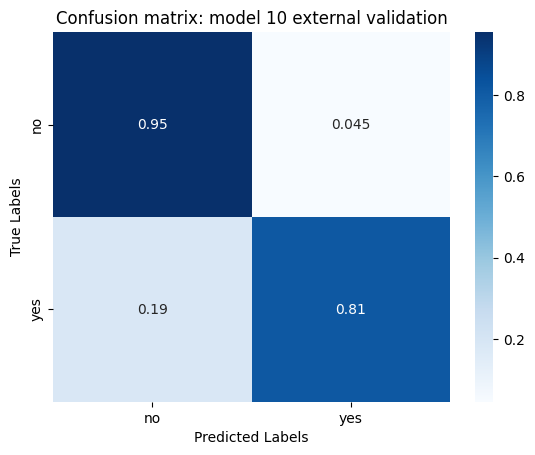

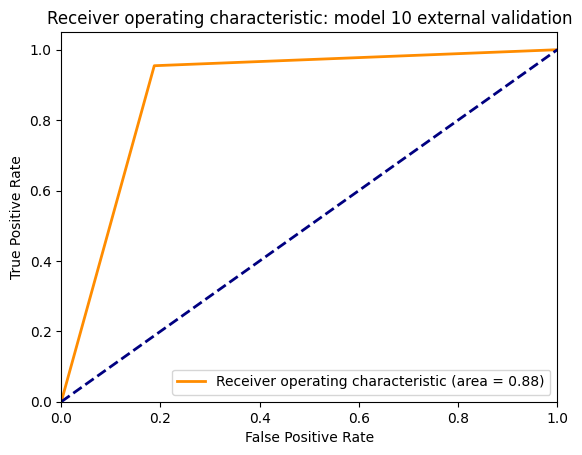

Classification Report 10:
              precision    recall  f1-score   support

           1     0.7778    0.9545    0.8571        22
           0     0.9630    0.8125    0.8814        32

    accuracy                         0.8704        54
   macro avg     0.8704    0.8835    0.8692        54
weighted avg     0.8875    0.8704    0.8715        54

Matthews correlation: 0.753778361444409
bestROC: 0.8976157082748948, fold 1


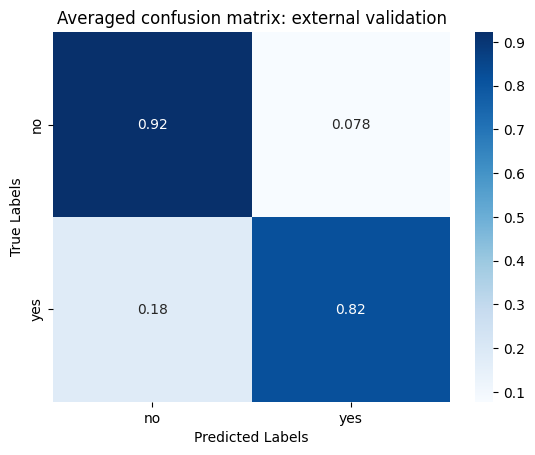

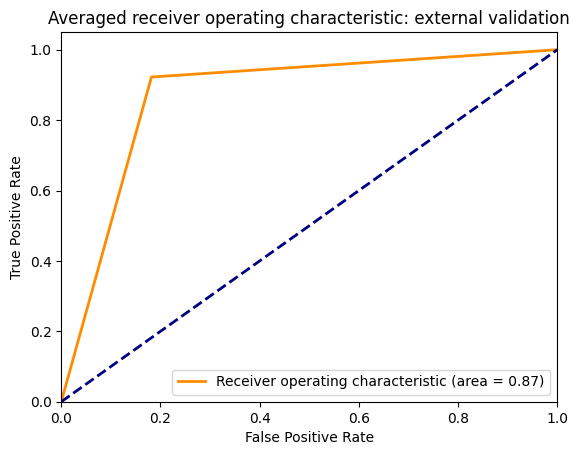

Classification Report
              precision    recall  f1-score   support

           1     0.7926    0.9224    0.8526       232
           0     0.9333    0.8182    0.8720       308

    accuracy                         0.8630       540
   macro avg     0.8630    0.8703    0.8623       540
weighted avg     0.8729    0.8630    0.8636       540

Matthews correlation: 0.7332240822960837


In [38]:
def getHeuristics(y_true, y_pred, confusionMatrixTitle, ROCtitle, fold=None):
    cm = confusion_matrix(y_true, y_pred, labels=[1,0], normalize='true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues')

    ax.set_title(confusionMatrixTitle)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['no', 'yes'])
    ax.yaxis.set_ticklabels(['no', 'yes'])


    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label=f'Receiver operating characteristic (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROCtitle)
    plt.legend(loc="lower right")
    plt.show()

    print(f'Classification Report {fold + 1}:' if fold else 'Classification Report')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    print(f"Matthews correlation: " + str(matthews_corrcoef(y_true, y_pred)))
    return roc_auc

y_pred, y_true = dict(), dict()
y_pred_total, y_true_total = list(), list()
bestModel = { 'model': None, 'fold': 0}
bestROC = 0

df_valid = pd.read_csv('valid.csv')

for fold in range(foldCount):
    # Load model architecture
    model = GRU(vocab=vocab, dimension=config['dimension'],
      sequenceDepth=config['sequence_feature_depth'],
      dropoutWithinLayers=config['dropout_within_layers'],
      dropoutOutput=config['dropout_output'],).to(device)

    # Load state dictionary
    model.load_state_dict(torch.load(destination_folder + f'/model{fold}.pt'))
    y_pred[fold], y_true[fold] = runModel(model, vocab, tokenizer, df_valid, foldCount)
    y_pred_total += y_pred[fold]
    y_true_total += y_true[fold]
    roc = getHeuristics(y_pred[fold], y_true[fold], f"Confusion matrix: model {fold + 1} external validation", f"Receiver operating characteristic: model {fold + 1} external validation", fold)
    if roc > bestROC: 
        bestROC = roc
        bestModel['model'], bestModel['fold'] = model, fold + 1
print("bestROC: " + str(bestROC) + ', fold ' + str(bestModel['fold']))

totalExternalRoc = getHeuristics(y_pred_total, y_true_total, f"Averaged confusion matrix: external validation", f"Averaged receiver operating characteristic: external validation", None)



## Use the model to search for amyloidogenic sequences in the Gut Phage Database, and analyze results.

In [39]:
def compressHeaders(FASTApath, CSVpath):
    print("Converting to CSV...")
    fastaToCSV(FASTApath, CSVpath)

    print("Reading CSV as dataframe...")
    df_realData = pd.read_csv(CSVpath, engine='python')

    # Generate in-memory index for headers & compress dataframe
    realDatasetIndex = {}
    print("Generating header index...")
    for index in range(len(df_realData.index)):
        realDatasetIndex[index] = df_realData.at[index, 'header']
        df_realData.at[index, 'header'] = index
    print("Writing compressed CSV...")
    df_realData.to_csv(CSVpath, index=False)
    
    return realDatasetIndex


## Load gut phage database


In [41]:
#### Parse FASTA into CSV

gpdDatasetPath = './GPD_proteome.faa'
gpdCSVOutputPath = './GPD_proteome.csv'

gpdDatasetIndex = compressHeaders(gpdDatasetPath, gpdCSVOutputPath)
print("done!")

Converting to CSV...
Reading CSV as dataframe...
Generating header index...
Writing compressed CSV...
done!


In [42]:
#### Chunk CSV into bins
gpdChunkFolder = "."

print("Reading data...")
df_gpd = pd.read_csv(gpdCSVOutputPath)

print("Chunking...")
n = 760000
chunks = [df_gpd[i:i+n] for i in range(0,df_gpd.shape[0],n)]

for i in range(0,df_gpd.shape[0],n):
    df_gpd[i:i+n].to_csv(gpdChunkFolder + f"/gpd{int(i/n)}.csv", index=False)
    print(f"Saved chunk {int(i/n)}.")

print("done!")

Reading data...
Chunking...
Saved chunk 0.
Saved chunk 1.
Saved chunk 2.
Saved chunk 3.
Saved chunk 4.
Saved chunk 5.
Saved chunk 6.
Saved chunk 7.
Saved chunk 8.
Saved chunk 9.
done!


## Generate predictions with GRU model

In [43]:
# Load model architecture
best_model = GRU(vocab=vocab, dimension=config['dimension'],
    sequenceDepth=config['sequence_feature_depth'],
    dropoutWithinLayers=config['dropout_within_layers'],
    dropoutOutput=config['dropout_output'],).to(device)

# Load state dictionary
model.load_state_dict(torch.load(destination_folder + f'/model{5}.pt'))
gpd_predictions = list()

df_gpd = pd.read_csv(gpdCSVOutputPath)
gpd_predictions, null = runModel(best_model, vocab, tokenizer, df_gpd, foldCount=10)
    
print("done!")

Evaluating FOLD 1
--------------------------------


100%|██████████| 47387/47387 [1:16:49<00:00, 10.28batch/s]  


Evaluating FOLD 2
--------------------------------


100%|██████████| 47387/47387 [1:13:49<00:00, 10.70batch/s]


Evaluating FOLD 3
--------------------------------


100%|██████████| 47387/47387 [1:26:17<00:00,  9.15batch/s]    


Evaluating FOLD 4
--------------------------------


100%|██████████| 47387/47387 [5:11:07<00:00,  2.54batch/s]      


Evaluating FOLD 5
--------------------------------


100%|██████████| 47387/47387 [2:11:35<00:00,  6.00batch/s]     


Evaluating FOLD 6
--------------------------------


100%|██████████| 47387/47387 [5:38:08<00:00,  2.34batch/s]      


Evaluating FOLD 7
--------------------------------


100%|██████████| 47387/47387 [3:11:26<00:00,  4.13batch/s]      


Evaluating FOLD 8
--------------------------------


100%|██████████| 47387/47387 [1:10:23<00:00, 11.22batch/s]


Evaluating FOLD 9
--------------------------------


100%|██████████| 47387/47387 [1:10:45<00:00, 11.16batch/s]


Evaluating FOLD 10
--------------------------------


100%|██████████| 47387/47387 [1:09:56<00:00, 11.29batch/s]


done!


In [44]:
### Write positives
from Bio.SeqIO import FastaIO
from Bio import SeqIO
output_file = "./output/gpdPositivesAlt.fasta"
fasta_out = FastaIO.FastaWriter(output_file, wrap=None)

print("generating sequence-header index...")

gpdProteinDict = SeqIO.index(gpdDatasetPath, "fasta")

print("finding positives...")
positiveCount = 0
for index, prediction in enumerate(gpd_predictions):
    if prediction == 1:
        fasta_out.write_record(gpdProteinDict[gpdDatasetIndex[index]])
        positiveCount += 1

print(f"found {positiveCount} positives")
print("done!")

generating sequence-header index...
finding positives...
found 3960381 positives
done!


## Store annotations for predictions

In [45]:
#### Load GPD annotations to find results with functional annotations
import pandas as pd
print("Reading annotations...")
df_gpdAnnotations = pd.read_csv("./GPD_proteome_orthology_assignment.txt", sep="\t", dtype=str, na_filter=False)

# Generate in-memory index for protein annotations
positiveAnnotationsIndex = {}
print("Generating protein label index...")
for index in range(len(df_gpdAnnotations.index)):
    positiveAnnotationsIndex[df_gpdAnnotations.at[index, 'query_name']] = index
print("done!")
df_gpdAnnotations.head()

Reading annotations...


Generating protein label index...
done!


,query_name,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,best_tax_level,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,...,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,tax_scope,eggNOG OGs,COG Functional Category,eggNOG free text description,Unnamed: 21
0,uvig_48111_1,1408422.JHYF01000013_gene535,1.8e-37,163.7,Clostridiaceae,,,4.1.99.22,"ko:K03639,ko:K06871","ko00790,ko01100,ko04122,map00790,map01100,map0...",...,RC03420,"ko00000,ko00001,ko01000",,,,Bacteria,"1TQPS@1239,24A6D@186801,36G9K@31979,COG0641@1,...",C,4Fe-4S single cluster domain,
1,uvig_48111_2,NA,,,,,,,,,...,,,,,,,,,,
2,uvig_48111_5,NA,,,,,,,,,...,,,,,,,,,,
3,uvig_87711_3,NA,,,,,,,,,...,,,,,,,,,,
4,uvig_48111_6,1111454.HMPREF1250_0782,5.8e-19,100.5,Negativicutes,,,3.4.21.88,ko:K01356,,...,,"ko00000,ko00002,ko01000,ko01002,ko03400",,,,Bacteria,"1VGT2@1239,4H5RI@909932,COG1974@1,COG1974@2",K,Helix-turn-helix XRE-family like proteins,


In [46]:
from Bio import SeqIO

print("generating sequence-header index...")

gpdResultsPath = './output/gpdPositives.fasta'
gpdPositivesDict = SeqIO.index(gpdResultsPath, "fasta")

collectiveProteinDescriptions = ''
print("consolidating functional annotations...")

foundCount = 0
gpdAmyloidAnnotations = list()
for header in gpdPositivesDict:
    annotationRow = df_gpdAnnotations.iloc[positiveAnnotationsIndex[header]]
    if annotationRow['eggNOG free text description'] != "":
        foundCount += 1
        gpdAmyloidAnnotations.append(annotationRow)

df_gpdAmyloidAnnotations = pd.DataFrame(gpdAmyloidAnnotations)
print("writing to csv...")
df_gpdAmyloidAnnotations.to_csv('output/gpdPositiveAnnotations.csv')

print(f"matched {foundCount} annotations")
print("done!")


generating sequence-header index...
consolidating functional annotations...
writing to csv...
matched 106373 annotations
done!


### Determine if any shared functional annotations between predictions & reference are under- or over-represented

In [47]:
from scipy import stats
import numpy as np

# Fisher F-test for homogenous variance
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) # calculate F test statistic 
    dfn = x.size-1 # define degrees of freedom numerator 
    dfd = y.size-1 # define degrees of freedom denominator 
    p = 1-stats.f.cdf(f, dfn, dfd) # find p-value of F test statistic 
    return f, p

df_referenceAnnotationCounts = df_gpdAnnotations['eggNOG free text description'].value_counts()

df_testAnnotationCounts = df_gpdAmyloidAnnotations['eggNOG free text description'].value_counts()

referenceAnnotationCounts = df_referenceAnnotationCounts.to_dict()
testAnnotationCounts = df_testAnnotationCounts.to_dict()

# only examine shared annotations
referenceAnnotations = list(referenceAnnotationCounts.keys())
for uniqueAnnotation in referenceAnnotations:
    if uniqueAnnotation not in testAnnotationCounts:
        del referenceAnnotationCounts[uniqueAnnotation]

# calculate frequencies
referenceCountList, testCountList = np.zeros(shape=(len(referenceAnnotationCounts))), np.zeros(shape=(len(referenceAnnotationCounts)))
totalReferenceCount = sum(referenceAnnotationCounts.values())
totalTestCount = sum(testAnnotationCounts.values())
for index, uniqueAnnotation in enumerate(referenceAnnotationCounts.keys()):
    referenceCountList[index] = referenceAnnotationCounts[uniqueAnnotation] / totalReferenceCount
    testCountList[index] = testAnnotationCounts[uniqueAnnotation] / totalTestCount


# check for homoscedasticity (homogenous variance) by F-test
fTestResult = f_test(referenceCountList, testCountList)
print(f'homogenous variance should have p > 0.05;\n f-val: {fTestResult[0]} f-test pval: {fTestResult[1]}')

# check differential annotation frequencies with chi-square test
chiSquareTest = stats.chisquare(f_obs=referenceCountList, f_exp=testCountList)
print(chiSquareTest)

homogenous variance should have p > 0.05;
 f-val: 1.0393881142832353 f-test pval: 0.07663065376593736
Power_divergenceResult(statistic=0.04388157871412747, pvalue=1.0)


## TODO: 

Determine significance of: 
-   functional annotations not shared between predictions & reference
-   differences between families/clades


## Notes

- S100-A9: false negative
    - conditionally amyloidogenic in presence of calcium/zinc due to metallic ion affinity

